## Summary of the report and findings

In this project, we tried to verify a hypothesis that is
proposed within the paper ”GRAM: graph-based attention model for healthcare representation learning.”

The primary hypothesis we plan to verify is where it says "Compared to the basic RNN, GRAM achieved...3% improved area under the ROC curve for predicting heart failure using an order of magnitude less training data." The data result is shown as below.

<img src="https://github.com/chadyuu/dlh-gram/blob/master/img/table_2c.png?raw=true" />

The paper was not reproducible partly due to not having the baseline model code available to compare GRAM against. The paper's models were built from scratch and used Theano. We built a baseline RNN but now 6+ years later Pytorch has replaced Theano and its improvements likely helped it outperform the paper's custom models. 

The hypothesis we tested performed for 8 runs as the paper stated, however the key purpose of GRAM is for very sparse data which were in the 2 runs where our RNN results varied wildly. 

Although the paper's Table 2c was run on Sutter HF data, we expected to see the hypothesis generalize against the MIMIC HF data. We note that the Sutter and MIMIC data may vary in distribution, but since our baseline models mismatched we could not isolate variables to evaluate its influence on the results. 

Due to these factors we feel the evidence we got from running the code is inconclusive in regard to supporting the claims of the paper, and so we have to conclude the paper was not reproducible.

 Also, we reexamined the hyperparameter tuning described in the additional document by the author.

<img src="https://github.com/chadyuu/dlh-gram/blob/master/img/hyperparameter.png?raw=true" />

We set the default parameters to (200,100,100,0.001,0.6) to reflect what the tuning document shows was best for the heart prediction tasks on the Sutter dataset. Then, we changed each parameter to observe its influence on AUC.

We found that (embDimSize=400, HiddenDimSize=400, attentionDimSize=200, L2=0.0001, drouout=0.8) appear to be optimal parameters for heart failure prediction on the MIMIC-III dataset, which we found achieved 0.921 AUC. 

## Overview of the MIMIC Ⅲ dataset

We use three CSV files from the MIMIC Ⅲ dataset.

- ADMISSIONS.csv
- DIAGNOSES_ICD.csv
- ccs_multi_dx_tool_2015.csv

### ADMISSIONS.csv

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
admissions_df = pd.read_csv('ADMISSIONS.csv')
admissions_df.keys()

Index([u'ROW_ID', u'SUBJECT_ID', u'HADM_ID', u'ADMITTIME', u'DISCHTIME',
       u'DEATHTIME', u'ADMISSION_TYPE', u'ADMISSION_LOCATION',
       u'DISCHARGE_LOCATION', u'INSURANCE', u'LANGUAGE', u'RELIGION',
       u'MARITAL_STATUS', u'ETHNICITY', u'EDREGTIME', u'EDOUTTIME',
       u'DIAGNOSIS', u'HOSPITAL_EXPIRE_FLAG', u'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [16]:
# Display the first few rows
print(admissions_df.head())

   ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      25          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare      NaN           CA

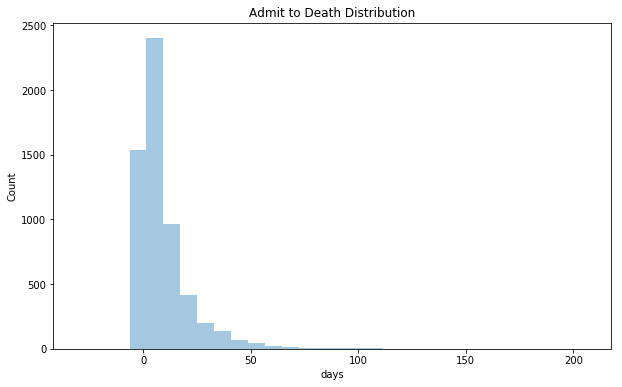

In [31]:
# Plot the distribution of days from admission to death
admissions_with_death = admissions_df.where(admissions_df['DEATHTIME'] != np.nan)
admissions_with_death['admit_to_death'] = (pd.to_datetime(admissions_with_death['DEATHTIME']) - pd.to_datetime(admissions_with_death['ADMITTIME'])).dt.days
plt.figure(figsize=(10, 6))
sns.distplot(admissions_with_death['admit_to_death'], kde=False, bins=30)
plt.title('Admit to Death Distribution')
plt.xlabel('days')
plt.ylabel('Count')
plt.show()


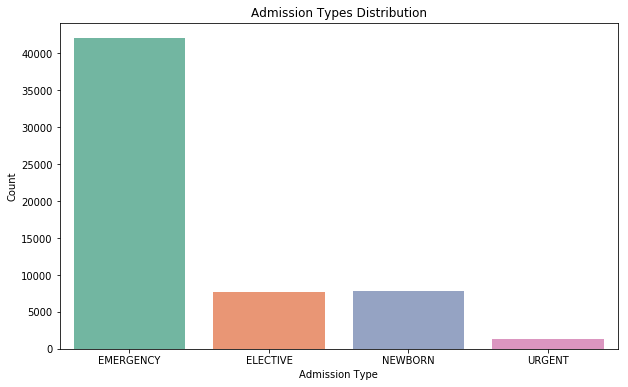

In [32]:
# Plot the distribution of admission types
plt.figure(figsize=(10, 6))
sns.countplot(data=admissions_df, x='ADMISSION_TYPE', palette='Set2')
plt.title('Admission Types Distribution')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.show()

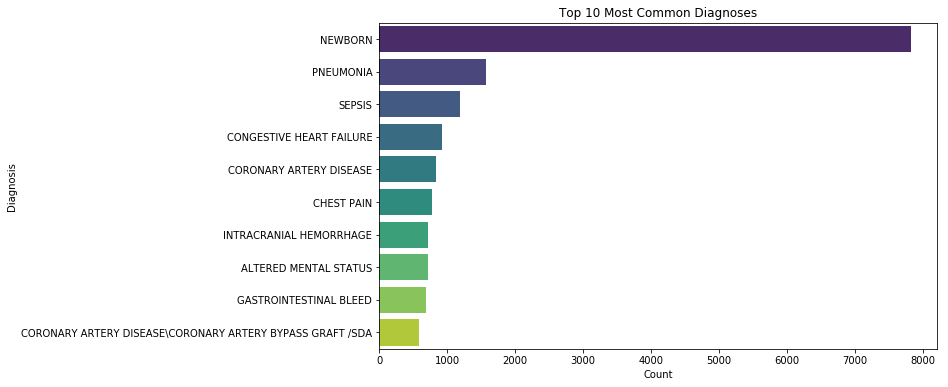

In [33]:
# Visualize the most common diagnoses
diagnoses_df = admissions_df['DIAGNOSIS'].value_counts().reset_index()
diagnoses_df.columns = ['DIAGNOSIS', 'COUNT']
diagnoses_df = diagnoses_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=diagnoses_df, x='COUNT', y='DIAGNOSIS', palette='viridis')
plt.title('Top 10 Most Common Diagnoses')
plt.xlabel('Count')
plt.ylabel('Diagnosis')
plt.show()

### DIAGNOSES_ICD.csv

   ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
0    1297         109   172335      1.0     40301
1    1298         109   172335      2.0       486
2    1299         109   172335      3.0     58281
3    1300         109   172335      4.0      5855
4    1301         109   172335      5.0      4254


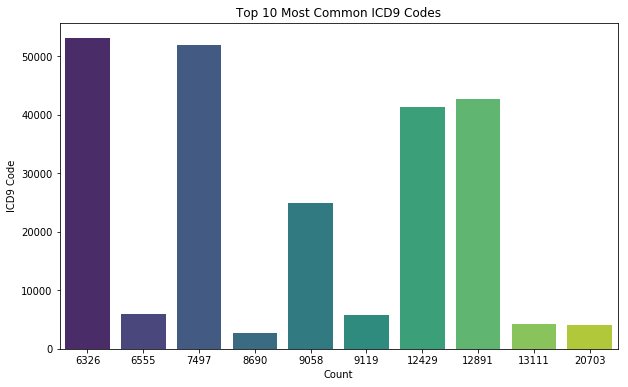

In [34]:
# Load the dataset
diagnoses_icd_df = pd.read_csv('DIAGNOSES_ICD.csv')

# Display the first few rows
print(diagnoses_icd_df.head())

# Plot the most common ICD9 codes
icd9_counts = diagnoses_icd_df['ICD9_CODE'].value_counts().reset_index()
icd9_counts.columns = ['ICD9_CODE', 'COUNT']
icd9_counts = icd9_counts.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=icd9_counts, x='COUNT', y='ICD9_CODE', palette='viridis')
plt.title('Top 10 Most Common ICD9 Codes')
plt.xlabel('Count')
plt.ylabel('ICD9 Code')
plt.show()

### ccs_multi_dx_tool_2015.csv

Index([u''ICD-9-CM CODE'', u''CCS LVL 1'', u''CCS LVL 1 LABEL'',
       u''CCS LVL 2'', u''CCS LVL 2 LABEL'', u''CCS LVL 3'',
       u''CCS LVL 3 LABEL'', u''CCS LVL 4'', u''CCS LVL 4 LABEL''],
      dtype='object')
  'ICD-9-CM CODE' 'CCS LVL 1'                  'CCS LVL 1 LABEL' 'CCS LVL 2'  \
0         '01000'         '1'  Infectious and parasitic diseases       '1.1'   
1         '01001'         '1'  Infectious and parasitic diseases       '1.1'   
2         '01002'         '1'  Infectious and parasitic diseases       '1.1'   
3         '01003'         '1'  Infectious and parasitic diseases       '1.1'   
4         '01004'         '1'  Infectious and parasitic diseases       '1.1'   

     'CCS LVL 2 LABEL' 'CCS LVL 3'  'CCS LVL 3 LABEL' 'CCS LVL 4'  \
0  Bacterial infection     '1.1.1'  Tuberculosis [1.]         ' '   
1  Bacterial infection     '1.1.1'  Tuberculosis [1.]         ' '   
2  Bacterial infection     '1.1.1'  Tuberculosis [1.]         ' '   
3  Bacterial infection     

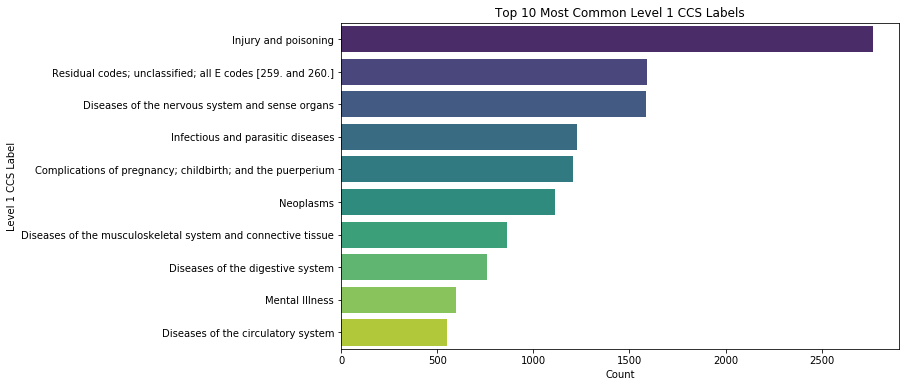

In [61]:
# Load the dataset
ccs_multi_dx_df = pd.read_csv('ccs_multi_dx_tool_2015.csv')

print(ccs_multi_dx_df.keys())
# Display the first few rows
print(ccs_multi_dx_df.head())

# Plot the distribution of single-level CCS categories
single_level_counts = ccs_multi_dx_df.iloc[:,2].value_counts().reset_index()
single_level_counts.columns = ['CCS LVL 1 LABEL', 'COUNT']
single_level_counts = single_level_counts.head(10)
print(single_level_counts)

plt.figure(figsize=(10, 6))
sns.barplot(data=single_level_counts, x='COUNT', y='CCS LVL 1 LABEL', palette='viridis')
plt.title('Top 10 Most Common Level 1 CCS Labels')
plt.xlabel('Count')
plt.ylabel('Level 1 CCS Label')
plt.show()


We preprocessed these files by running `$ python process_mimic_hfs.py ADMISSIONS.csv DIAGNOSES_ICD.csv output/output` to generate 
- `output.hfs`: contains the heart failure label (0: normal, 1: heart failure) for each patient
- `output2.seqs`: contains a list of visit (in ICD9 codes) for each patient
- `output2.types`: contains the map from ICD9 codes to ICD-9 labels

In [33]:
import pickle

with open('./output/output.hfs', 'rb') as f:
	hfs = pickle.load(f)
with open('./output2/output2.seqs', 'rb') as f:
	seqs = pickle.load(f)
with open('./output2/output2.types', 'rb') as f:
	types = pickle.load(f)

print("number of patients:", len(hfs))
print("number of heart failure patients:", sum(hfs))
print("ratio of heart failure patients: %10.2f" % (float(sum(hfs)) / len(hfs)))
print("number of unique ICD9 codes:", len(types))

('number of patients:', 5447)
('number of heart failure patients:', 1280)
ratio of heart failure patients:       0.23
('number of unique ICD9 codes:', 4512)


Also, we prepared ancestor information from medical ontologies data by running `python build_trees.py ccs_multi_dx_tool_2015.csv output/output.seqs output/output.types output2/output2` to produce:

- output2.level1.pk
- output2.level2.pk
- output2.level3.pk
- output2.level4.pk
- output2.level5.pk

## Overview of methodology and experiments

We implemented the GRAM model for heart faiure prediction in `gram_hf.py`. The following code imported it as `gram_hf` and train the model with 5 epochs.

In [36]:
import numpy as np
import gram_hf

if __name__ == '__main__':
	seq_file = 'output2/output2.seqs'
	tree_file = 'output2/output2'
	label_file = 'output/output.hfs'
	out_file = 'ipynb/gram_hf'
	inputDimSize = gram_hf.calculate_dimSize(seq_file)
	numClass = 1 # predicte a binary value (heart failure)
	numAncestors = gram_hf.get_rootCode(tree_file+'.level2.pk') - inputDimSize + 1

	gram_hf.train_GRAM(
		seqFile=seq_file,
		inputDimSize=inputDimSize,
		treeFile=tree_file,
		numAncestors=numAncestors,
		labelFile=label_file,
		numClass=numClass,
		outFile=out_file,
		embFile='',
		embDimSize=128,
		hiddenDimSize=128,
		attentionDimSize=128,
		batchSize=100,
		max_epochs=5,
		L2=0.001,
		dropoutRate=0.5,
		logEps=1e-8,
		train_ratio=0.7
	)

 Building the model ...  done!!
Constructing the optimizer ...  done!!
Loading data ...  done!!
Optimization start !!
Epoch:0, Duration:12.177816, Train_Cost:0.647768, Valid_Cost:0.536243, Test_Cost:0.493310
Epoch:1, Duration:12.339224, Train_Cost:0.570731, Valid_Cost:0.518706, Test_Cost:0.486453
Epoch:2, Duration:12.307639, Train_Cost:0.534188, Valid_Cost:0.498042, Test_Cost:0.445167
Epoch:3, Duration:12.324813, Train_Cost:0.511874, Valid_Cost:0.485034, Test_Cost:0.437686
Epoch:4, Duration:16.401006, Train_Cost:0.491118, Valid_Cost:0.465700, Test_Cost:0.432930
Best Epoch:4, Avg_Duration:13.110100, Train_Cost:0.491118, Valid_Cost:0.465700, Test_Cost:0.432930


We also implemented the GRAM model without the attention mechanism in `gram_hf_no_attention.py`. The following code imported it as `gram_hf_no_attention` and train the model with 5 epochs.

In [39]:
import gram_hf_no_attention as gram_hf

if __name__ == '__main__':
	seq_file = 'output2/output2.seqs'
	tree_file = 'output2/output2'
	label_file = 'output/output.hfs'
	out_file = 'ipynb/gram_hf_no_attention' # for no attention
	inputDimSize = gram_hf.calculate_dimSize(seq_file)
	numClass = 1 # predicte a binary value (heart failure)
	numAncestors = gram_hf.get_rootCode(tree_file+'.level2.pk') - inputDimSize + 1

	gram_hf.train_GRAM(
		seqFile=seq_file,
		inputDimSize=inputDimSize,
		treeFile=tree_file,
		numAncestors=numAncestors,
		labelFile=label_file,
		numClass=numClass,
		outFile=out_file,
		embFile='',
		embDimSize=128,
		hiddenDimSize=128,
		attentionDimSize=128,
		batchSize=100,
		max_epochs=5,
		L2=0.001,
		dropoutRate=0.5,
		logEps=1e-8,
		train_ratio=0.7
	)

Building the model ...  done!!
Constructing the optimizer ...  done!!
Loading data ...  done!!
Optimization start !!
Epoch:0, Duration:2.722397, Train_Cost:0.516371, Valid_Cost:0.576333, Test_Cost:0.501965
Epoch:1, Duration:2.729736, Train_Cost:0.479058, Valid_Cost:0.493964, Test_Cost:0.458061
Epoch:2, Duration:2.700339, Train_Cost:0.441143, Valid_Cost:0.483906, Test_Cost:0.435884
Epoch:3, Duration:2.674544, Train_Cost:0.399495, Valid_Cost:0.518985, Test_Cost:0.508718
Epoch:4, Duration:2.727133, Train_Cost:0.379071, Valid_Cost:0.391843, Test_Cost:0.395522
Best Epoch:4, Avg_Duration:2.710830, Train_Cost:0.379071, Valid_Cost:0.391843, Test_Cost:0.395522


We calculated AUC for each model as follows.

In [47]:
from sklearn.metrics import roc_auc_score
import pickle

with open('./ipynb/gram_hf_0.7.test_set', 'rb') as f:
    test_data = pickle.load(f)
with open('./ipynb/gram_hf_0.7_4.test_probs', 'rb') as f:
    y_pred_probs = pickle.load(f)

y_true_labels = test_data[1]
auc = roc_auc_score(y_true_labels, y_pred_probs)

print("GRAM with attention AUC:", auc)

('GRAM with attention AUC:', 0.8514355428251791)


In [70]:
from sklearn.metrics import roc_auc_score
import pickle

with open('./ipynb/gram_hf_no_attention_0.7.test_set', 'rb') as f:
    test_data = pickle.load(f)
with open('./ipynb/gram_hf_no_attention_0.7_4.test_probs', 'rb') as f:
    y_pred_probs = pickle.load(f)

y_true_labels = test_data[1]
auc = roc_auc_score(y_true_labels, y_pred_probs)

print("GRAM without attention AUC:", auc)

('GRAM without attention AUC:', 0.8606023782657755)


Also, we examined the hyperparameter setting.

In [63]:
import gram_hf

seq_file = 'output2/output2.seqs'
tree_file = 'output2/output2'
label_file = 'output/output.hfs'
inputDimSize = gram_hf.calculate_dimSize(seq_file)
numClass = 1 # predicte a binary value (heart failure)
numAncestors = gram_hf.get_rootCode(tree_file+'.level2.pk') - inputDimSize + 1

def train_gram_hyperparam(embDimSize=200, hiddenDimSize=100,attentionDimSize=100,L2=0.001,dropoutRate=0.6, out_file=''):
    gram_hf.train_GRAM(
        seqFile=seq_file,
        inputDimSize=inputDimSize,
        treeFile=tree_file,
        numAncestors=numAncestors,
        labelFile=label_file,
        numClass=numClass,
        outFile=out_file,
        embFile='',
        embDimSize=embDimSize, 
        hiddenDimSize=hiddenDimSize,
        attentionDimSize=attentionDimSize,
        batchSize=100,
        max_epochs=10,
        L2=L2, 
        dropoutRate=dropoutRate,
        logEps=1e-8,
        train_ratio=0.7
    )

if __name__ == '__main__':
    # default settting
    train_gram_hyperparam(out_file='ipynb/default')

    # change parameters
    for embDimSize in [100,300,400,500]:
        train_gram_hyperparam(embDimSize=embDimSize, out_file='ipynb/embDimSize'+str(embDimSize))
    for hiddenDimSize in [200,300,400,500]:
        train_gram_hyperparam(hiddenDimSize=hiddenDimSize, out_file='ipynb/hiddenDimSize'+str(hiddenDimSize))
    for attentionDimSize in [200,300,400,500]:
        train_gram_hyperparam(attentionDimSize=attentionDimSize, out_file='ipynb/attentionDimSize'+str(attentionDimSize))
    for L2 in [0.0001,0.01, 0.1]:
        train_gram_hyperparam(L2=L2, out_file='ipynb/L2'+str(L2))
    for dropoutRate in [0.0,0.2,0.4,0.8]:
        train_gram_hyperparam(dropoutRate=dropoutRate, out_file='ipynb/dropoutRate'+str(dropoutRate))

    train_gram_hyperparam(embDimSize=500, hiddenDimSize=500, out_file='ipynb/embDimSize500_hiddenDimSize500')

    # possibly best
    train_gram_hyperparam(
        embDimSize=400, 
        hiddenDimSize=400, 
        attentionDimSize=200,
        L2=0.0001,
        dropoutRate=0.8,
        out_file='ipynb/best')

Building the model ... 

/Users/yutaro/Dropbox/001.UIUC/002.DLH/gram/gram_hf.py:318: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 2 is not part of the computational graph needed to compute the outputs: mask.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  get_cost = theano.function(inputs=[x, y, mask, lengths], outputs=cost_noreg, name='get_cost', on_unused_input='warn')
/Users/yutaro/Dropbox/001.UIUC/002.DLH/gram/gram_hf.py:318: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 3 is not part of the computational graph needed to compute the outputs: lengths.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ig

 done!!
Constructing the optimizer ... 

/Users/yutaro/Dropbox/001.UIUC/002.DLH/gram/gram_hf.py:212: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 2 is not part of the computational graph needed to compute the outputs: mask.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  f_grad_shared = theano.function([x, y, mask, lengths], cost, updates=zgup + rg2up, name='adadelta_f_grad_shared', on_unused_input='warn')
/Users/yutaro/Dropbox/001.UIUC/002.DLH/gram/gram_hf.py:212: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 3 is not part of the computational graph needed to compute the outputs: lengths.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use

 done!!
Loading data ...  done!!
Optimization start !!
Epoch:0, Duration:15.518463, Train_Cost:0.663092, Valid_Cost:0.543491, Test_Cost:0.487005
Epoch:1, Duration:15.450127, Train_Cost:0.589917, Valid_Cost:0.516489, Test_Cost:0.467639
Epoch:2, Duration:24.573496, Train_Cost:0.551992, Valid_Cost:0.510130, Test_Cost:0.481835
Epoch:3, Duration:16.919093, Train_Cost:0.526536, Valid_Cost:0.483689, Test_Cost:0.443998
Epoch:4, Duration:19.470055, Train_Cost:0.507182, Valid_Cost:0.475735, Test_Cost:0.434812
Epoch:5, Duration:16.917265, Train_Cost:0.468032, Valid_Cost:0.485129, Test_Cost:0.439006
Epoch:6, Duration:16.213000, Train_Cost:0.469495, Valid_Cost:0.444409, Test_Cost:0.421364
Epoch:7, Duration:16.980874, Train_Cost:0.441806, Valid_Cost:0.415169, Test_Cost:0.405869
Epoch:8, Duration:15.653448, Train_Cost:0.403117, Valid_Cost:0.375289, Test_Cost:0.390198
Epoch:9, Duration:14.615877, Train_Cost:0.347842, Valid_Cost:0.357074, Test_Cost:0.392752
Best Epoch:9, Avg_Duration:17.231170, Train_C

In [74]:
files = [
    ('default_0.7_9.test_probs', 'default_0.7.test_set'),
    
    ('embDimSize100_0.7_9.test_probs', 'embDimSize100_0.7.test_set'),
    ('embDimSize300_0.7_8.test_probs', 'embDimSize300_0.7.test_set'),
    ('embDimSize400_0.7_9.test_probs', 'embDimSize400_0.7.test_set'),
    ('embDimSize500_0.7_9.test_probs', 'embDimSize500_0.7.test_set'),
    
    ('hiddenDimSize200_0.7_9.test_probs', 'hiddenDimSize200_0.7.test_set'),
    ('hiddenDimSize300_0.7_9.test_probs', 'hiddenDimSize300_0.7.test_set'),
    ('hiddenDimSize400_0.7_9.test_probs', 'hiddenDimSize400_0.7.test_set'),
    ('hiddenDimSize500_0.7_9.test_probs', 'hiddenDimSize500_0.7.test_set'),
    
    ('attentionDimSize200_0.7_9.test_probs', 'attentionDimSize200_0.7.test_set'),
    ('attentionDimSize300_0.7_9.test_probs', 'attentionDimSize300_0.7.test_set'),
    ('attentionDimSize400_0.7_9.test_probs', 'attentionDimSize400_0.7.test_set'),
    ('attentionDimSize500_0.7_9.test_probs', 'attentionDimSize500_0.7.test_set'),
    
    ('L20.0001_0.7_9.test_probs', 'L20.0001_0.7.test_set'),
    ('L20.01_0.7_9.test_probs', 'L20.01_0.7.test_set'),
    ('L20.1_0.7_9.test_probs', 'L20.1_0.7.test_set'),

    ('dropoutRate0.0_0.7_9.test_probs', 'dropoutRate0.0_0.7.test_set'),
    ('dropoutRate0.2_0.7_8.test_probs', 'dropoutRate0.2_0.7.test_set'),
    ('dropoutRate0.4_0.7_9.test_probs', 'dropoutRate0.4_0.7.test_set'),
    ('dropoutRate0.8_0.7_9.test_probs', 'dropoutRate0.8_0.7.test_set'),

    # possibly best
    ('embDimSize500_hiddenDimSize500_0.7_9.test_probs', 'embDimSize500_hiddenDimSize500_0.7.test_set'),
    ('best_0.7_9.test_probs', 'best_0.7.test_set'),
]

for log, test_set in files:
    with open('./ipynb/'+test_set, 'rb') as f:
        test_data = pickle.load(f)
    with open('./ipynb/'+log, 'rb') as f:
        y_pred_probs = pickle.load(f)
    
    y_true_labels = test_data[1]
    for i, y in enumerate(y_true_labels):
        y_true_labels[i] = y > 0.5
    auc = roc_auc_score(y_true_labels, y_pred_probs)

    print("AUC: " + str(auc) +" for " + test_set)

AUC: 0.8502251926433855 for default_0.7.test_set
AUC: 0.8636981743482915 for embDimSize100_0.7.test_set
AUC: 0.8859859772974955 for embDimSize300_0.7.test_set
AUC: 0.8968935952704723 for embDimSize400_0.7.test_set
AUC: 0.8841391082949975 for embDimSize500_0.7.test_set
AUC: 0.9154539054287341 for hiddenDimSize200_0.7.test_set
AUC: 0.912907830145917 for hiddenDimSize300_0.7.test_set
AUC: 0.9216551418183221 for hiddenDimSize400_0.7.test_set
AUC: 0.9143399974925017 for hiddenDimSize500_0.7.test_set
AUC: 0.8895591624955395 for attentionDimSize200_0.7.test_set
AUC: 0.8783863283472692 for attentionDimSize300_0.7.test_set
AUC: 0.8600044363432957 for attentionDimSize400_0.7.test_set
AUC: 0.8585192257616527 for attentionDimSize500_0.7.test_set
AUC: 0.8701356942395047 for L20.0001_0.7.test_set
AUC: 0.8618416611212375 for L20.01_0.7.test_set
AUC: 0.8666251965010753 for L20.1_0.7.test_set
AUC: 0.4837253710615398 for dropoutRate0.0_0.7.test_set
AUC: 0.8684865318404074 for dropoutRate0.2_0.7.test_set

## Summary of the key results

GRAM underperformed RNN at the 10% and 20% ratio of used trainig dataset, which contradicts the statement by the paper, i.e., GRAM overperformed RNN even with small training dataset.

<img src="https://github.com/chadyuu/dlh-gram/blob/master/img/auc.png?raw=true" />

The AUC is a little higher with no-attention  which seems counter-intuitive. The main contributor to GRAM's high performance appears to be from using medical ontologies and not the attention mechanism.

<img src="https://github.com/chadyuu/dlh-gram/blob/master/img/wo_attention.png?raw=true" />

Below are the reulsts for each hyperparemeter setting.

<img src="https://github.com/chadyuu/dlh-gram/blob/master/img/hyper1.png?raw=true" />

<img src="https://github.com/chadyuu/dlh-gram/blob/master/img/hyper2.png?raw=true" />

## References

- Edward Choi, Mohammad Taha Bahadori, Le Song, Walter F Stewart, and Jimeng Sun. 2017. Gram: graph-based attention model for healthcare represen-tation learning. In Proceedings of the 23rd ACM SIGKDD international conference on knowledge discovery and data mining, pages 